# Detección de valores Anomalos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
headers = ["Fecha", "Id_Estacion", "Nombre_Estacion", "Coord_Geo_Estacion", "Temp_Minima_(oC)", "Temp_Maxima_(oC)", "Temp_Promedio_(oC)", "Unidades_Calor_(oD)", "Evaporacion_(mm)", "Precipitacion_(mm)"
]

In [3]:
df = pd.read_csv("datos/datos_sonora.zip", names = headers, low_memory=False)

In [4]:
df.tail()

,Fecha,Id_Estacion,Nombre_Estacion,Coord_Geo_Estacion,Temp_Minima_(oC),Temp_Maxima_(oC),Temp_Promedio_(oC),Unidades_Calor_(oD),Evaporacion_(mm),Precipitacion_(mm)
3270288,1977-06-28,26110,TEONADEPA-SON,29.9916666667N -109.796388889W,NaN,NaN,NaN,NaN,NaN,0.0
3270289,1977-06-29,26110,TEONADEPA-SON,29.9916666667N -109.796388889W,NaN,NaN,NaN,NaN,NaN,0.0
3270290,1977-06-30,26110,TEONADEPA-SON,29.9916666667N -109.796388889W,NaN,NaN,NaN,NaN,NaN,0.0
3270291,2016-04-01,26313,EL MOLINITO-SON,29.2133333333N -110.728611111W,NaN,NaN,NaN,NaN,5.45,NaN
3270292,2016-01-01,26223,PUNTA DE AGUA II-SON,28.4733333333N -110.305W,NaN,NaN,NaN,NaN,2.37,NaN


In [5]:
df.shape

(3270293, 10)

corregir el tipo de dato...

In [6]:
df.dtypes

Fecha                  object
Id_Estacion            object
Nombre_Estacion        object
Coord_Geo_Estacion     object
Temp_Minima_(oC)       object
Temp_Maxima_(oC)       object
Temp_Promedio_(oC)     object
Unidades_Calor_(oD)    object
Evaporacion_(mm)       object
Precipitacion_(mm)     object
dtype: object

In [7]:
df.isnull().sum()

Fecha                        0
Id_Estacion                  0
Nombre_Estacion              0
Coord_Geo_Estacion           0
Temp_Minima_(oC)        619065
Temp_Maxima_(oC)        906234
Temp_Promedio_(oC)     1083711
Unidades_Calor_(oD)     630742
Evaporacion_(mm)       2060090
Precipitacion_(mm)      560866
dtype: int64

<AxesSubplot:>

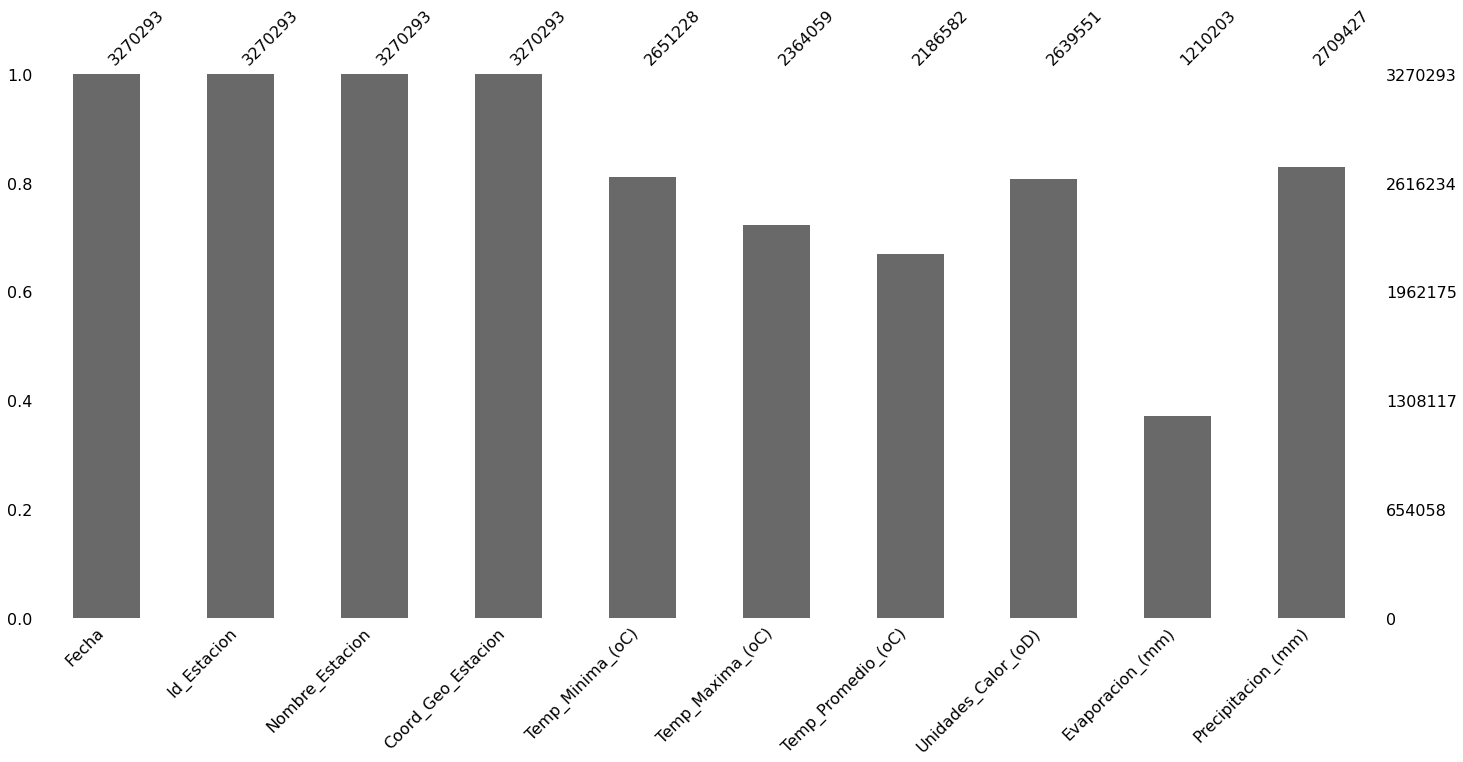

In [8]:
msno.bar(df)

<AxesSubplot:>

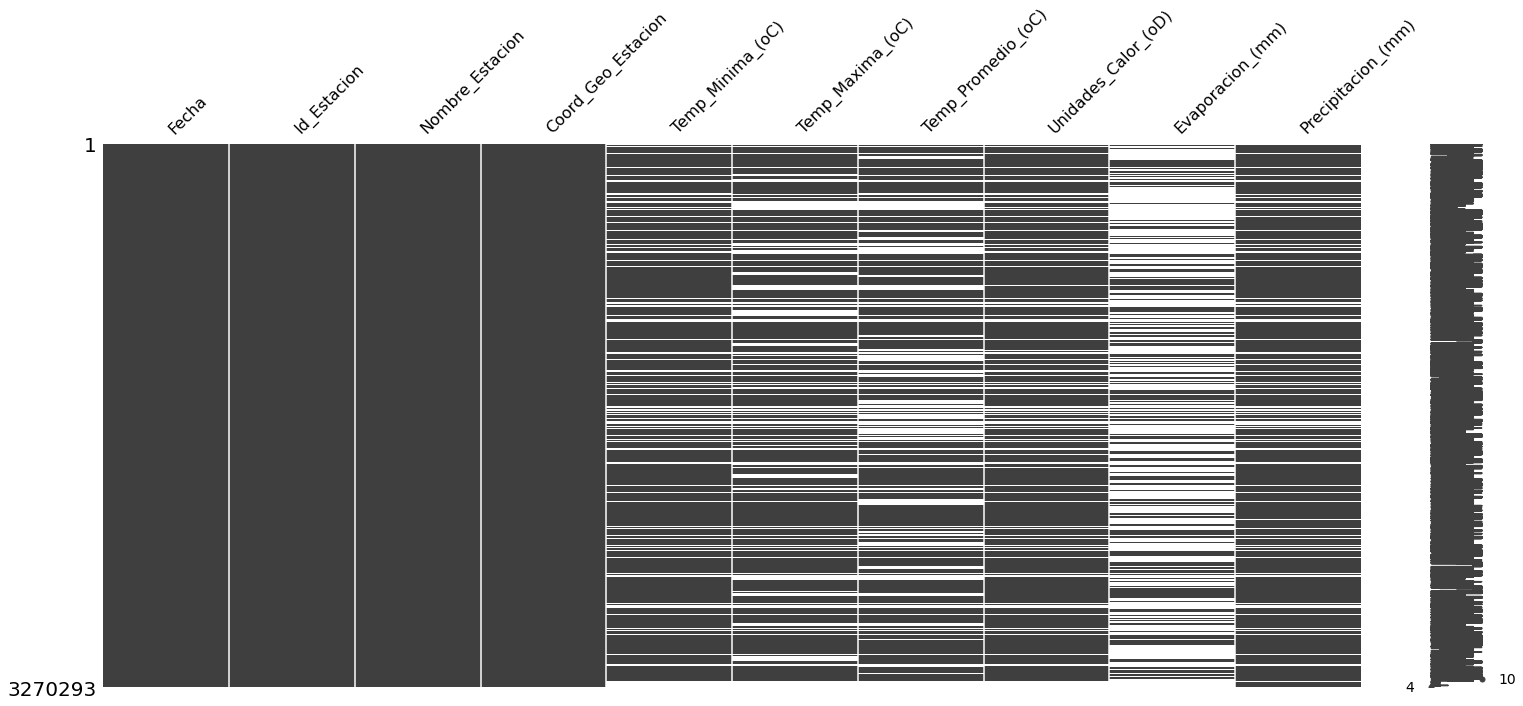

In [9]:
msno.matrix(df)